## Clustering

In [38]:
# Import all necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# also import these "new" libraries 
# Note: you may have to download and add them to your environment (using e.g. 'conda install -c conda-forge folium')
# !important! Install this version of plotly=5.10.0 or else some maps and animations may not render correctly
import plotly.express as px
import folium
from folium import plugins
from folium.plugins import HeatMap
from branca.element import Figure
import haversine as hs

# import the necessary libraries for the machine learning models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from shapely.geometry import Polygon
from h3 import h3

from haversine import haversine, Unit

In [39]:
# Load Data
taxi_df_clustering = pd.read_parquet('data/prepared/taxi_data_prepared.gzip')
ddf_weather = pd.read_parquet("data/prepared/weather_data_hourly_prepared.gzip")

### General Data Prep
Before we can start with the clustering, we add addtional features to our clustering dataframe.

As City Center we will consider the central business district of the city which widely know as the Loop, the main section of Downtown Chicago (Wikipedia). This corresponds to the location of 41.881111 (Latitude), -87.629722 (Longtitude). We will investigate clustering trip types based on their start distance to the city center.

In [40]:
taxi_df_clustering['pickup_centroid_location'] = gpd.GeoSeries.from_wkt(taxi_df_clustering['pickup_centroid_location'])

# Converting the taxi_df_clustering to a GeoDataFrame
# !Note: The crs is set to 4326 which is the WGS84 coordinate system and must be used to show the coordinates properly on a map
taxi_df_clustering = gpd.GeoDataFrame(taxi_df_clustering, geometry='pickup_centroid_location', crs=4326)
#taxi_geo_df_locations = taxi_geo_df_locations['pickup_centroid_location']

In [41]:
# Calculating the distance between start coordinates and the city center
for i in range(0, len(taxi_df_clustering)):
    start_coordinates = (taxi_df_clustering['pickup_centroid_location'][i].y, taxi_df_clustering['pickup_centroid_location'][i].x)
    city_center = (41.881111, -87.629722)

    # Units need to be set to "Unit.MILES"
    taxi_df_clustering.at[i, 'distance_to_city_center'] = haversine(start_coordinates, city_center, unit=Unit.MILES)

In [42]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,distance_to_city_center
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.64265 41.87926),POINT (-87.6129454143 41.8919715078),0.677254
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.63186 41.89204),POINT (-87.6327464887 41.8809944707),0.763264
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.62414 41.84925),POINT (-87.6209929134 41.8849871918),2.220297
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.62099 41.88499),POINT (-87.657005027 41.8790669938),0.522834
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.63840 41.90157),POINT (-87.6209929134 41.8849871918),1.482234
...,...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.63275 41.88099),POINT (-87.6308650266 41.9058577688),0.155795
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.62414 41.84925),POINT (-87.6209929134 41.8849871918),2.220297
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.62621 41.89251),POINT (-87.6462934762 41.9290776551),0.807842
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.63275 41.88099),POINT (-87.6219716519 41.8774061234),0.155795


In [43]:
#Additional Data of weekday, hour and date
taxi_df_clustering.loc[:,"weekday"] = taxi_df_clustering["trip_start_timestamp"].dt.weekday
taxi_df_clustering.loc[:,"hour"] = taxi_df_clustering["trip_start_timestamp"].dt.hour
taxi_df_clustering.loc[:,"date"] = taxi_df_clustering["trip_start_timestamp"].dt.date
taxi_df_clustering.loc[:,"day_of_year"] = taxi_df_clustering["trip_start_timestamp"].dt.dayofyear

# add datetime columns to weather df
ddf_weather["hour"] = ddf_weather.time.dt.hour
ddf_weather["date"] = ddf_weather.time.dt.date

# Merge with weather df
taxi_df_clustering = taxi_df_clustering.merge(ddf_weather, on=["date", "hour"], how="inner")

In [44]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,distance_to_city_center,...,hour,date,day_of_year,time,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h)
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.64265 41.87926),POINT (-87.6129454143 41.8919715078),0.677254,...,0,2016-01-01,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.63186 41.89204),POINT (-87.6327464887 41.8809944707),0.763264,...,0,2016-01-01,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.62414 41.84925),POINT (-87.6209929134 41.8849871918),2.220297,...,0,2016-01-01,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.62099 41.88499),POINT (-87.657005027 41.8790669938),0.522834,...,0,2016-01-01,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.63840 41.90157),POINT (-87.6209929134 41.8849871918),1.482234,...,0,2016-01-01,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.63275 41.88099),POINT (-87.6308650266 41.9058577688),0.155795,...,23,2016-12-31,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.62414 41.84925),POINT (-87.6209929134 41.8849871918),2.220297,...,23,2016-12-31,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.62621 41.89251),POINT (-87.6462934762 41.9290776551),0.807842,...,23,2016-12-31,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.63275 41.88099),POINT (-87.6219716519 41.8774061234),0.155795,...,23,2016-12-31,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6


### Importing POI Data

In [ ]:
def get_n_poi_for_resolution(resolution="h3_5"):
    # get polygons from hexagon id
    df_hex = gpd.read_file("hexagons.csv", index_col=[0])
    df_hex = df_hex[resolution].to_frame()
    df_hex['geometry'] = df_hex.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[resolution], geo_json=True)), axis=1)
    df_hex = df_hex.set_geometry("geometry")
    df_hex.crs = "EPSG:4326"
    df_hex = df_hex.to_crs("EPSG:4326")
    
    # load point of interest
    poi = gpd.read_file("POI.geojson")
    
    # join
    poi_by_hex = gpd.sjoin(poi, df_hex, how='inner', op='within')
    
    return poi_by_hex.groupby(resolution).size().to_frame().reset_index().rename(columns={0:"n_poi"})

In [ ]:
df = pd.read_csv("prep_data/h3_5/h3_5_time_bin_1.csv", index_col=[0]).dropna()

In [ ]:
poi_by_hex = get_n_poi_for_resolution()

In [ ]:
df_poi = df.merge(poi_by_hex, how="left", on="h3_5")

#### Separate POI

In [ ]:
def get_n_poi_for_resolution_and_amenity(resolution="h3_5"):
    # get polygons from hexagon id
    df_hex = gpd.read_file("hexagons.csv", index_col=[0])
    df_hex = df_hex[resolution].to_frame()
    df_hex['geometry'] = df_hex.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[resolution], geo_json=True)), axis=1)
    df_hex = df_hex.set_geometry("geometry")
    df_hex.crs = "EPSG:4326"
    df_hex = df_hex.to_crs("EPSG:4326")
    
    # load point of interest
    poi = gpd.read_file("POI.geojson")
    
    # join
    poi_by_hex = gpd.sjoin(poi, df_hex, how='inner', op='within').groupby([resolution, "amenity"]).size().to_frame().reset_index()
    
    # generate according dataframe with features
    poi_features = []
    for hexagon in poi_by_hex[resolution].unique():
        di = {resolution: hexagon}
        for amenity in poi_by_hex.amenity.unique():
            n = poi_by_hex[(poi_by_hex[resolution] == hexagon) & (poi_by_hex["amenity"] == amenity)][0].values
            di[amenity] = n[0] if n.size > 0 else 0
        poi_features.append(di)
    
    return pd.DataFrame(poi_features)

In [ ]:
poi_by_hex = get_n_poi_for_resolution_and_amenity()

### Functions to use for Clustering
Next we create a number of functions to help with frequent Clustering Steps:

In [45]:
# This function is used to standardize features
def scalingData(dataframe):
    newDataframe = dataframe.copy()
    scaler = StandardScaler()
    newDataframe[newDataframe.columns] = pd.DataFrame(scaler.fit_transform(newDataframe[newDataframe.columns]))
    return newDataframe

In [46]:
# This function calculates the Loss per cluster amount and plots the result of it in the range of 0-10 on the x-axis
def calcAndPlotLossKM(clusterAmount, dataframe):
    k_max = clusterAmount

    clusters = []
    losses = []

    for k in range(k_max):
        model = KMeans(n_clusters=k+1, n_init=10)
        model.fit(dataframe)
        clusters.append(k+1)
        losses.append(model.inertia_)

    fig = plt.subplots(figsize=(12,7))
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,10])
    plt.grid(True)
    plt.show()

In [47]:
# This function calculates for a defined amount of clusters KMeans on the given dataframe
def calcKMeans(numClusters, dataframe):
    result = KMeans(n_clusters=numClusters, n_init=10)
    result.fit(dataframe)

    dataframe['ClusterKM'] = result.predict(dataframe)

In [48]:
# This function calculates for a defined amount of clusters GMM on the given dataframe
def calcGMM(numClusters, dataframe):
    gmm = GaussianMixture(n_components=numClusters).fit(dataframe)
    dataframe['ClusterGMM'] = gmm.predict(dataframe)

In [49]:
# This function describes every KMeans or GMM cluster with the describe() function for the original dataframe
def describeData(originalDataframe, scaledDataframe, numClusters, method):   
    if(method == 'KMeans'):
        for i in range(0, numClusters):
            display(originalDataframe[scaledDataframe['ClusterKM'] == i].describe())
    elif(method == 'GMM'):
        for i in range(0, numClusters):    
            display(originalDataframe[scaledDataframe['ClusterGMM'] == i].describe())
    else:
        print('Error: The wrong method has been chosen. Either use "KMeans" or "GMM"!')

In [50]:
# This function removes outliers for a set of columns where values is n times larger than std
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        df = df.reset_index(drop=True)
        
    return df

## Clustering

Initially we start clustering trip/customer types with a sample of the complete dataset to allow shorter run times and easier tweaking of parameters. Furthemore, we begin with a hard clustering approach using KMeans to estimate good parameters (number of clusters) for the following soft clustering approach. The features considered for clustering are x,y,z.

In [51]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,distance_to_city_center,...,hour,date,day_of_year,time,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h)
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.64265 41.87926),POINT (-87.6129454143 41.8919715078),0.677254,...,0,2016-01-01,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.63186 41.89204),POINT (-87.6327464887 41.8809944707),0.763264,...,0,2016-01-01,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.62414 41.84925),POINT (-87.6209929134 41.8849871918),2.220297,...,0,2016-01-01,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.62099 41.88499),POINT (-87.657005027 41.8790669938),0.522834,...,0,2016-01-01,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.63840 41.90157),POINT (-87.6209929134 41.8849871918),1.482234,...,0,2016-01-01,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.63275 41.88099),POINT (-87.6308650266 41.9058577688),0.155795,...,23,2016-12-31,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.62414 41.84925),POINT (-87.6209929134 41.8849871918),2.220297,...,23,2016-12-31,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.62621 41.89251),POINT (-87.6462934762 41.9290776551),0.807842,...,23,2016-12-31,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.63275 41.88099),POINT (-87.6219716519 41.8774061234),0.155795,...,23,2016-12-31,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6


In [52]:
#Remove outliers in dataset as impact on clustering is significant
taxi_df_clustering = remove_outliers(taxi_df_clustering,['trip_miles'],3)

Working on column: trip_miles


Making Feature Selection without including inherently correlated features.
E.g trip miles and trip duration, trip miles with both pickup and dropoff location, day of the year/hour and temperature.

In [53]:
#Feature Selection for Clustering
#taxi_df_customer_types_cluster = taxi_df_clustering[['weekday','hour','pickup_census_tract']]
#taxi_df_customer_types_cluster = taxi_df_clustering[['weekday','trip_miles','temperature_2m (°C)']]
#taxi_df_customer_types_cluster = taxi_df_clustering[['hour','trip_miles','temperature_2m (°C)']]
#taxi_df_customer_types_cluster = taxi_df_clustering[['trip_miles','pickup_census_tract','dropoff_census_tract','distance_to_city_center','weekday','hour','day_of_year','temperature_2m (°C)','precipitation (mm)']]
taxi_df_customer_types_cluster = taxi_df_clustering[['pickup_census_tract','dropoff_census_tract','distance_to_city_center','weekday','temperature_2m (°C)','precipitation (mm)']]
taxi_df_customer_types_cluster

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm)
0,17031281900,17031081402,0.677254,4,-4.0,0.0
1,17031081700,17031839100,0.763264,4,-4.0,0.0
2,17031841000,17031320100,2.220297,4,-4.0,0.0
3,17031320100,17031833100,0.522834,4,-4.0,0.0
4,17031838300,17031320100,1.482234,4,-4.0,0.0
...,...,...,...,...,...,...
20320767,17031839100,17031080202,0.155795,5,-1.6,0.0
20320768,17031841000,17031320100,2.220297,5,-1.6,0.0
20320769,17031081500,17031070200,0.807842,5,-1.6,0.0
20320770,17031839100,17031320400,0.155795,5,-1.6,0.0


In [23]:
#Removing Outliers larger than three times standard deviation for trip durations
#taxi_df_customer_types_cluster = remove_outliers(taxi_df_customer_types_cluster,["trip_miles"],3)

In [54]:
taxi_df_customer_types_cluster

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm)
0,17031281900,17031081402,0.677254,4,-4.0,0.0
1,17031081700,17031839100,0.763264,4,-4.0,0.0
2,17031841000,17031320100,2.220297,4,-4.0,0.0
3,17031320100,17031833100,0.522834,4,-4.0,0.0
4,17031838300,17031320100,1.482234,4,-4.0,0.0
...,...,...,...,...,...,...
20320767,17031839100,17031080202,0.155795,5,-1.6,0.0
20320768,17031841000,17031320100,2.220297,5,-1.6,0.0
20320769,17031081500,17031070200,0.807842,5,-1.6,0.0
20320770,17031839100,17031320400,0.155795,5,-1.6,0.0


In [55]:
#Scaling the Data
taxi_df_customer_types_cluster_scaled = scalingData(taxi_df_customer_types_cluster)
taxi_df_customer_types_cluster_scaled

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm)
0,-0.268053,-0.837017,-0.393525,0.532740,-1.480231,-0.235339
1,-0.851588,1.417775,-0.370502,0.532740,-1.480231,-0.235339
2,1.361590,-0.126688,0.019510,0.532740,-1.480231,-0.235339
3,-0.156709,1.399920,-0.434859,0.532740,-1.480231,-0.235339
4,1.353721,-0.126688,-0.178051,0.532740,-1.480231,-0.235339
...,...,...,...,...,...,...
20320767,1.356052,-0.840588,-0.533106,1.062358,-1.256637,-0.235339
20320768,1.361590,-0.126688,0.019510,1.062358,-1.256637,-0.235339
20320769,-0.852171,-0.870352,-0.358569,1.062358,-1.256637,-0.235339
20320770,1.356052,-0.125796,-0.533106,1.062358,-1.256637,-0.235339


In [56]:
#Sampling original and scaled Data
taxi_df_customer_types_cluster_sample = taxi_df_customer_types_cluster.sample(n=100000, random_state=1)
taxi_df_customer_types_cluster_scaled_sample = taxi_df_customer_types_cluster_scaled.sample(n=100000, random_state=1)

In [57]:
taxi_df_customer_types_cluster_sample

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm)
20069056,17031841900,17031837000,1.138701,3,-2.1,0.0
8572993,17031081500,17031980000,0.807842,4,20.1,0.0
20224567,17031320100,17031838200,0.522834,3,-0.1,0.0
10983198,17031839100,17031070500,0.155795,4,19.5,0.0
12966122,17031839100,17031062800,0.155795,3,24.0,0.0
...,...,...,...,...,...,...
17403265,17031081500,17031241400,0.807842,4,14.2,0.0
12122087,17031081403,17031839000,0.878185,3,24.3,0.0
7643821,17031320100,17031081500,0.522834,2,12.2,0.0
7099359,17031320100,17031980100,0.522834,0,11.4,0.2


In [58]:
taxi_df_customer_types_cluster_scaled_sample

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm)
20069056,1.364214,1.411526,-0.270007,0.003123,-1.303219,-0.235339
8572993,-0.852171,1.837072,-0.358569,0.532740,0.765023,-0.235339
20224567,-0.156709,1.415097,-0.434859,0.003123,-1.116891,-0.235339
10983198,1.356052,-0.869459,-0.533106,0.532740,0.709124,-0.235339
12966122,1.356052,-0.892373,-0.533106,0.003123,1.128363,-0.235339
...,...,...,...,...,...,...
17403265,-0.852171,-0.360887,-0.358569,0.532740,0.215355,-0.235339
12122087,-0.852454,1.417478,-0.339740,0.003123,1.156312,-0.235339
7643821,-0.156709,-0.836725,-0.434859,-0.526495,0.029027,-0.235339
7099359,-0.156709,1.837370,-0.434859,-1.585731,-0.045505,0.128004


### Hard Clustering with KMeans (Sample)

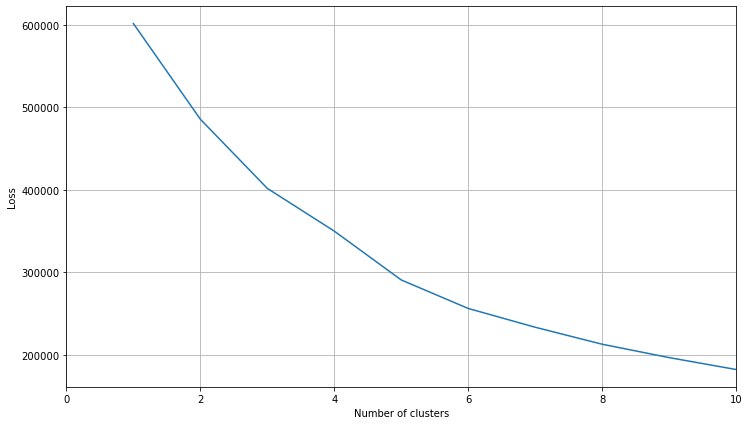

In [59]:
#Calculating the Loss with increasing number of Clusters
calcAndPlotLossKM(10, taxi_df_customer_types_cluster_scaled_sample)

In [60]:
# Calculating KMeans
calcKMeans(6, taxi_df_customer_types_cluster_scaled_sample)

# Adding the clusters from KMeans into the original dataframe 
taxi_df_customer_types_cluster_sample.loc[:, 'ClusterKM'] = taxi_df_customer_types_cluster_scaled_sample['ClusterKM']
taxi_df_customer_types_cluster_sample

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM
20069056,17031841900,17031837000,1.138701,3,-2.1,0.0,4
8572993,17031081500,17031980000,0.807842,4,20.1,0.0,4
20224567,17031320100,17031838200,0.522834,3,-0.1,0.0,4
10983198,17031839100,17031070500,0.155795,4,19.5,0.0,2
12966122,17031839100,17031062800,0.155795,3,24.0,0.0,2
...,...,...,...,...,...,...,...
17403265,17031081500,17031241400,0.807842,4,14.2,0.0,1
12122087,17031081403,17031839000,0.878185,3,24.3,0.0,4
7643821,17031320100,17031081500,0.522834,2,12.2,0.0,3
7099359,17031320100,17031980100,0.522834,0,11.4,0.2,4


In [61]:
describeData(taxi_df_customer_types_cluster_sample, taxi_df_customer_types_cluster_sample, 6, 'KMeans')

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM
count,1.786000e+03,1.786000e+03,1786.000000,1786.000000,1786.000000,1786.000000,1786.0
mean,1.703137e+10,1.703134e+10,1.715463,2.821948,17.049552,3.351792,0.0
std,3.354683e+05,3.255147e+05,2.967160,1.719778,7.906026,1.865335,0.0
min,1.703102e+10,1.703101e+10,0.155795,0.000000,1.400000,1.700000,0.0
25%,1.703108e+10,1.703108e+10,0.522834,1.000000,9.475000,2.200000,0.0
50%,1.703128e+10,1.703124e+10,0.807842,3.000000,20.000000,2.800000,0.0
75%,1.703184e+10,1.703183e+10,1.329146,4.000000,23.900000,3.400000,0.0
max,1.703198e+10,1.703198e+10,15.594652,6.000000,29.300000,11.000000,0.0


,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM
count,2.756600e+04,2.756600e+04,27566.000000,27566.000000,27566.000000,27566.000000,27566.0
mean,1.703114e+10,1.703115e+10,1.450365,4.732025,10.162969,0.068516,1.0
std,1.044299e+05,1.060056e+05,1.267413,0.946826,10.408394,0.231449,0.0
min,1.703101e+10,1.703101e+10,0.473808,3.000000,-18.700000,0.000000,1.0
25%,1.703108e+10,1.703108e+10,0.758631,4.000000,1.600000,0.000000,1.0
50%,1.703108e+10,1.703108e+10,0.878185,5.000000,8.900000,0.000000,1.0
75%,1.703128e+10,1.703128e+10,1.632596,5.000000,19.900000,0.000000,1.0
max,1.703141e+10,1.703177e+10,9.969402,6.000000,30.400000,1.900000,1.0


,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM
count,1.471300e+04,1.471300e+04,14713.000000,14713.000000,14713.000000,14713.000000,14713.0
mean,1.703184e+10,1.703116e+10,0.701354,2.715150,11.673506,0.071814,2.0
std,2.517011e+03,1.087338e+05,1.078668,1.784152,10.838442,0.236860,0.0
min,1.703183e+10,1.703101e+10,0.155795,0.000000,-19.500000,0.000000,2.0
25%,1.703184e+10,1.703108e+10,0.155795,1.000000,2.800000,0.000000,2.0
50%,1.703184e+10,1.703108e+10,0.155795,3.000000,11.800000,0.000000,2.0
75%,1.703184e+10,1.703128e+10,1.138701,4.000000,21.500000,0.000000,2.0
max,1.703184e+10,1.703160e+10,6.431553,6.000000,31.700000,1.800000,2.0


,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM
count,2.215700e+04,2.215700e+04,22157.000000,22157.000000,22157.000000,22157.000000,22157.0
mean,1.703117e+10,1.703116e+10,1.127983,1.434174,13.766724,0.074220,3.0
std,1.111764e+05,1.112941e+05,0.949024,1.054638,10.746955,0.244674,0.0
min,1.703101e+10,1.703101e+10,0.473808,0.000000,-19.600000,0.000000,3.0
25%,1.703108e+10,1.703108e+10,0.677254,1.000000,6.700000,0.000000,3.0
50%,1.703108e+10,1.703108e+10,0.807842,1.000000,15.500000,0.000000,3.0
75%,1.703128e+10,1.703128e+10,1.259778,2.000000,22.900000,0.000000,3.0
max,1.703141e+10,1.703142e+10,10.181607,3.000000,31.700000,1.800000,3.0


,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM
count,2.591100e+04,2.591100e+04,25911.000000,25911.000000,25911.000000,25911.000000,25911.0
mean,1.703135e+10,1.703186e+10,1.042483,2.733704,11.619470,0.063869,4.0
std,3.122688e+05,5.278156e+04,1.028828,1.797770,10.759433,0.219370,0.0
min,1.703101e+10,1.703156e+10,0.155795,0.000000,-19.700000,0.000000,4.0
25%,1.703108e+10,1.703184e+10,0.522834,1.000000,3.100000,0.000000,4.0
50%,1.703128e+10,1.703184e+10,0.763264,3.000000,11.900000,0.000000,4.0
75%,1.703183e+10,1.703184e+10,1.259778,4.000000,21.200000,0.000000,4.0
max,1.703184e+10,1.703198e+10,9.505565,6.000000,31.700000,1.900000,4.0


,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM
count,7.867000e+03,7.867000e+03,7867.000000,7867.000000,7867.000000,7867.000000,7867.0
mean,1.703198e+10,1.703141e+10,14.140664,2.718825,12.807678,0.079484,5.0
std,1.851777e+04,3.636510e+05,2.714201,1.956365,10.364607,0.285475,0.0
min,1.703150e+10,1.703101e+10,8.059346,0.000000,-19.200000,0.000000,5.0
25%,1.703198e+10,1.703108e+10,15.594652,1.000000,4.900000,0.000000,5.0
50%,1.703198e+10,1.703132e+10,15.594652,3.000000,13.900000,0.000000,5.0
75%,1.703198e+10,1.703184e+10,15.594652,4.000000,21.900000,0.000000,5.0
max,1.703198e+10,1.703198e+10,16.418697,6.000000,31.700000,2.500000,5.0


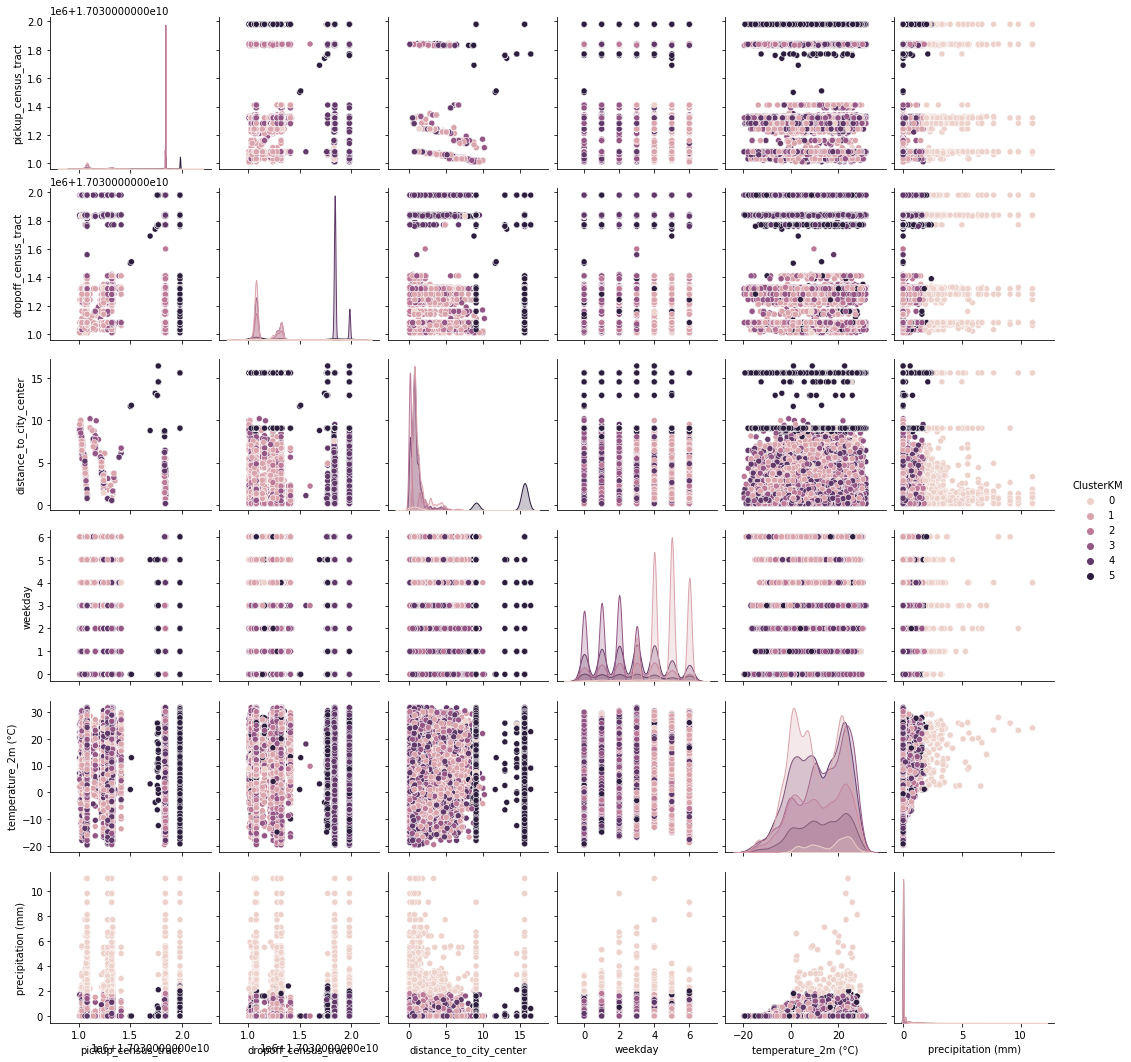

In [62]:
#Plot Clustering Results
sns.pairplot(taxi_df_customer_types_cluster_sample, hue="ClusterKM")

In [ ]:
#Plot Clustering Results
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}

fig = plt.scatter (x=taxi_df_customer_types_cluster_sample['hour'], y=taxi_df_customer_types_cluster_sample['trip_seconds'],c=taxi_df_customer_types_cluster_sample['ClusterKM'].map(colors))
fig

In [ ]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_customer_types_cluster_sample['hour'], ys=taxi_df_customer_types_cluster_sample['trip_seconds'], zs=taxi_df_customer_types_cluster_sample['distance_to_city_center'], c=taxi_df_customer_types_cluster_sample['ClusterKM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('KMeans Clustering of Customer Types')
plt.xlabel('hour')
plt.ylabel('trip seconds')
ax.set_zlabel('distance to city center')
ax.zaxis.labelpad = 0
plt.show()

### Soft Clustering with Gaussian Mixture Model (Sample)

In [63]:
taxi_df_customer_types_cluster_scaled_sample.drop(columns='ClusterKM',inplace=True)
taxi_df_customer_types_cluster_scaled_sample

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm)
20069056,1.364214,1.411526,-0.270007,0.003123,-1.303219,-0.235339
8572993,-0.852171,1.837072,-0.358569,0.532740,0.765023,-0.235339
20224567,-0.156709,1.415097,-0.434859,0.003123,-1.116891,-0.235339
10983198,1.356052,-0.869459,-0.533106,0.532740,0.709124,-0.235339
12966122,1.356052,-0.892373,-0.533106,0.003123,1.128363,-0.235339
...,...,...,...,...,...,...
17403265,-0.852171,-0.360887,-0.358569,0.532740,0.215355,-0.235339
12122087,-0.852454,1.417478,-0.339740,0.003123,1.156312,-0.235339
7643821,-0.156709,-0.836725,-0.434859,-0.526495,0.029027,-0.235339
7099359,-0.156709,1.837370,-0.434859,-1.585731,-0.045505,0.128004


In [64]:
# GMM
calcGMM(6, taxi_df_customer_types_cluster_scaled_sample)

# Adding the clusters from KMeans into the original dataframe 
taxi_df_customer_types_cluster_sample.loc[:, 'ClusterGMM'] = taxi_df_customer_types_cluster_scaled_sample['ClusterGMM']
taxi_df_customer_types_cluster_sample

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM,ClusterGMM
20069056,17031841900,17031837000,1.138701,3,-2.1,0.0,4,3
8572993,17031081500,17031980000,0.807842,4,20.1,0.0,4,3
20224567,17031320100,17031838200,0.522834,3,-0.1,0.0,4,3
10983198,17031839100,17031070500,0.155795,4,19.5,0.0,2,0
12966122,17031839100,17031062800,0.155795,3,24.0,0.0,2,0
...,...,...,...,...,...,...,...,...
17403265,17031081500,17031241400,0.807842,4,14.2,0.0,1,0
12122087,17031081403,17031839000,0.878185,3,24.3,0.0,4,3
7643821,17031320100,17031081500,0.522834,2,12.2,0.0,3,0
7099359,17031320100,17031980100,0.522834,0,11.4,0.2,4,4


In [65]:
describeData(taxi_df_customer_types_cluster_sample, taxi_df_customer_types_cluster_sample, 4, 'GMM')

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM,ClusterGMM
count,5.078900e+04,5.078900e+04,50789.000000,50789.000000,50789.000000,50789.0,50789.000000,50789.0
mean,1.703132e+10,1.703116e+10,0.879227,3.029376,11.822966,0.0,1.945067,0.0
std,3.032378e+05,1.093460e+05,0.572387,1.910611,10.916817,0.0,0.871304,0.0
min,1.703107e+10,1.703101e+10,0.155795,0.000000,-19.600000,0.0,1.000000,0.0
25%,1.703108e+10,1.703108e+10,0.522834,1.000000,2.800000,0.0,1.000000,0.0
50%,1.703124e+10,1.703108e+10,0.763264,3.000000,12.300000,0.0,2.000000,0.0
75%,1.703133e+10,1.703128e+10,1.259778,5.000000,21.500000,0.0,3.000000,0.0
max,1.703184e+10,1.703156e+10,3.711377,6.000000,31.700000,0.0,4.000000,0.0


,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM,ClusterGMM
count,4.364000e+03,4.364000e+03,4364.000000,4364.000000,4364.000000,4364.000000,4364.000000,4364.0
mean,1.703149e+10,1.703116e+10,0.441571,2.875115,12.641682,0.878941,1.732126,1.0
std,2.921433e+05,1.106421e+05,0.252667,1.700935,9.469441,0.866280,1.012851,0.0
min,1.703108e+10,1.703101e+10,0.155795,0.000000,-10.800000,0.100000,0.000000,1.0
25%,1.703128e+10,1.703108e+10,0.155795,2.000000,4.800000,0.200000,1.000000,1.0
50%,1.703132e+10,1.703108e+10,0.522834,3.000000,12.200000,0.500000,2.000000,1.0
75%,1.703184e+10,1.703128e+10,0.677254,4.000000,21.600000,1.300000,3.000000,1.0
max,1.703184e+10,1.703141e+10,0.934939,6.000000,30.400000,4.500000,3.000000,1.0


,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM,ClusterGMM
count,6.753000e+03,6.753000e+03,6753.000000,6753.000000,6753.000000,6753.0,6753.0,6753.0
mean,1.703198e+10,1.703141e+10,14.147529,2.682808,12.816378,0.0,5.0,2.0
std,4.153079e+01,3.643518e+05,2.712944,1.972357,10.495245,0.0,0.0,0.0
min,1.703198e+10,1.703101e+10,9.062283,0.000000,-19.200000,0.0,5.0,2.0
25%,1.703198e+10,1.703108e+10,15.594652,1.000000,4.900000,0.0,5.0,2.0
50%,1.703198e+10,1.703132e+10,15.594652,3.000000,13.900000,0.0,5.0,2.0
75%,1.703198e+10,1.703184e+10,15.594652,4.000000,21.900000,0.0,5.0,2.0
max,1.703198e+10,1.703198e+10,15.594652,6.000000,31.700000,0.0,5.0,2.0


,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterKM,ClusterGMM
count,2.222100e+04,2.222100e+04,22221.000000,22221.000000,22221.000000,22221.0,22221.000000,22221.0
mean,1.703134e+10,1.703186e+10,0.992540,2.703614,11.550664,0.0,3.999865,3.0
std,3.105624e+05,5.250513e+04,0.879872,1.820080,10.895282,0.0,0.020125,0.0
min,1.703103e+10,1.703176e+10,0.155795,0.000000,-19.700000,0.0,1.000000,3.0
25%,1.703108e+10,1.703184e+10,0.522834,1.000000,2.800000,0.0,4.000000,3.0
50%,1.703128e+10,1.703184e+10,0.763264,3.000000,11.900000,0.0,4.000000,3.0
75%,1.703183e+10,1.703184e+10,1.259778,4.000000,21.200000,0.0,4.000000,3.0
max,1.703184e+10,1.703198e+10,5.658777,6.000000,31.700000,0.0,4.000000,3.0


In [66]:
taxi_df_customer_types_cluster_sample.drop(columns='ClusterKM',inplace=True)
taxi_df_customer_types_cluster_sample

,pickup_census_tract,dropoff_census_tract,distance_to_city_center,weekday,temperature_2m (°C),precipitation (mm),ClusterGMM
20069056,17031841900,17031837000,1.138701,3,-2.1,0.0,3
8572993,17031081500,17031980000,0.807842,4,20.1,0.0,3
20224567,17031320100,17031838200,0.522834,3,-0.1,0.0,3
10983198,17031839100,17031070500,0.155795,4,19.5,0.0,0
12966122,17031839100,17031062800,0.155795,3,24.0,0.0,0
...,...,...,...,...,...,...,...
17403265,17031081500,17031241400,0.807842,4,14.2,0.0,0
12122087,17031081403,17031839000,0.878185,3,24.3,0.0,3
7643821,17031320100,17031081500,0.522834,2,12.2,0.0,0
7099359,17031320100,17031980100,0.522834,0,11.4,0.2,4


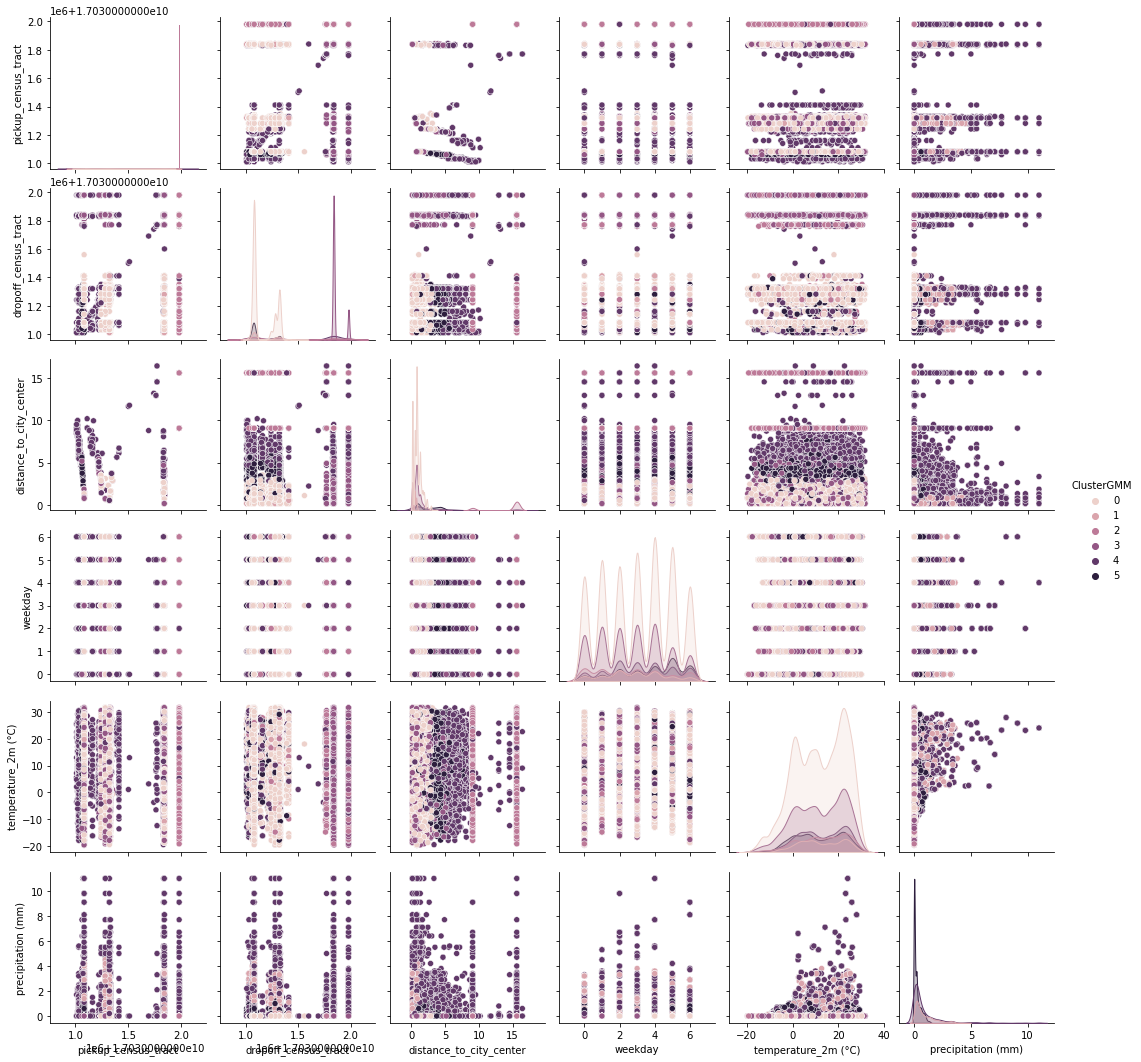

In [67]:
#Plot Clustering Results
sns.pairplot(taxi_df_customer_types_cluster_sample, hue="ClusterGMM")

In [ ]:
#Plot Clustering Results
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}

fig = plt.scatter (x=taxi_df_customer_types_cluster_sample['hour'], y=taxi_df_customer_types_cluster_sample['trip_seconds'],c=taxi_df_customer_types_cluster_sample['ClusterGMM'].map(colors))
fig


In [ ]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_customer_types_cluster_sample['hour'], ys=taxi_df_customer_types_cluster_sample['trip_seconds'], zs=taxi_df_customer_types_cluster_sample['distance_to_city_center'], c=taxi_df_customer_types_cluster_sample['ClusterGMM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('KMeans Clustering of Customer Types')
plt.xlabel('hour')
plt.ylabel('trip seconds')
ax.set_zlabel('distance to city center')
ax.zaxis.labelpad = 0
plt.show()

### Clustering on full Dataset

### Reference 3D Plot

In [ ]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_customer_types_cluster_sample['trip_miles'], ys=taxi_df_customer_types_cluster_sample['hour'], zs=taxi_df_customer_types_cluster_sample['temperature_2m (°C)'], c=taxi_df_customer_types_cluster_sample['ClusterGMM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('GMM Clustering of Customer Types')
plt.xlabel('trip_miles')
plt.ylabel('hour')
ax.set_zlabel('temperature_2m (°C)')
ax.zaxis.labelpad = 0
plt.show()